In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
from datetime import datetime, timedelta
# close = pd.read_parquet("../db/tw/Adj_close.parquet")
# df = close.loc['2020-01-01':] 
factor = pd.read_csv("../factor/data/ARIMA_freqW_factors_20d_bestlag_first100.csv", index_col=0)
factor = factor[factor != 0].dropna(how='all', axis=1)
factor.to_csv("../factor/data/ARIMA_freqW_factors_20d_bestlag_first100.csv")

In [66]:
factor = pd.read_csv("../factor/data/ARIMA_freqW_factors_20d_bestlag_first100.csv", index_col=0) # since 2010
close = pd.read_parquet("../db/tw/Adj_close.parquet")
close = close.loc[factor.index[0]:]
factor.columns = close.columns[:100]

In [88]:
pct_change = close.pct_change(fill_method=None).shift(-1)[:-1]
pct_change_w = pct_change.resample("W").sum()
pct_change_w = pct_change_w.shift(-1)
pct_change_w.index = pd.to_datetime(pct_change_w.index)
factor.index = pd.to_datetime(factor.index)

# fit stock list
pct_change_w_filtered = pct_change_w[list(factor.columns)]


In [104]:
ics = pd.Series([0] * len(pct_change_w_filtered), index=pct_change_w_filtered.index)
for index, i in enumerate(list(pct_change_w_filtered.index)):
    ic = st.spearmanr(factor.loc[i].fillna(0), pct_change_w_filtered.loc[i].fillna(0))
    ics[index] = ic[0]

/var/folders/zc/_sy5126x4ks5w74_nsrx_mv40000gp/T/ipykernel_12755/3359943838.py:4: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ics[index] = ic[0]
/var/folders/zc/_sy5126x4ks5w74_nsrx_mv40000gp/T/ipykernel_12755/3359943838.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.08248512888301389' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ics[index] = ic[0]
/var/folders/zc/_sy5126x4ks5w74_nsrx_mv40000gp/T/ipykernel_12755/3359943838.py:3: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  ic = st.spearmanr(factor.loc[i].fillna(0), pct_change_w_filtered.loc[i].fillna(0))


stationary


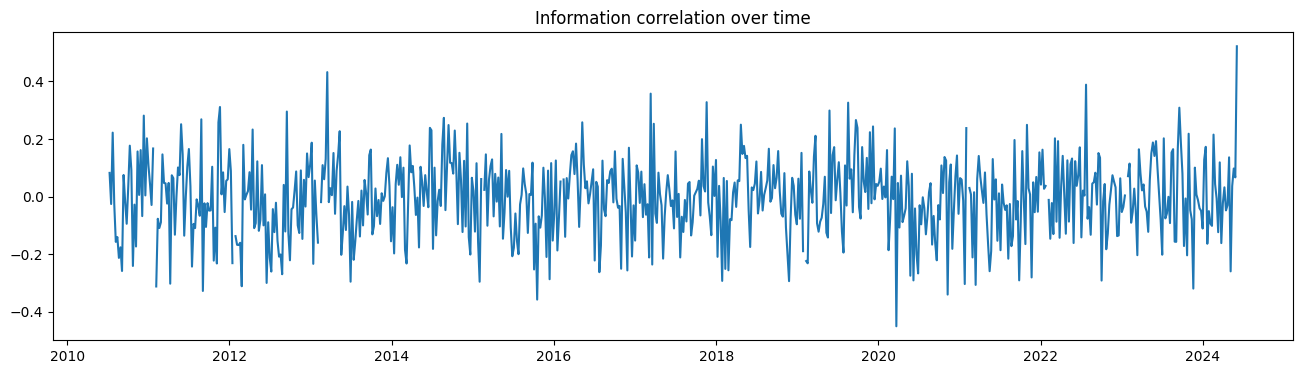

In [124]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
ics_dropna = [i for i in list(ics) if i > 0 or i < 0]
ics_ma = ics.rolling(20).mean()
res = adfuller(ics_dropna)
plt.figure(figsize=(16, 4))
plt.plot(ics)
plt.title("Information correlation over time")
res
if res[1] < 0.05 and res[0] < res[4]['5%']:
    print("stationary")
# t-test , p-value, {}: corresponding t-test critical value, res[0] needs to be smaller than value inside {}

In [9]:
ma20 = df.rolling(window=int(2)).mean()
diff_ma20 = df/ma20 - 1
diff_ma20.dropna(how='all', axis=0, inplace=True)
# def get_demean_weighting(self, data):
df1 = diff_ma20.dropna(axis='columns', how='all').copy()
demean = df1.sub(df1.mean(axis=1), axis=0)
weighting = demean.div(demean.abs().sum(axis=1), axis=0)
# 計算出來的因子（diff_ma20）是當天計算出來的，所以要再下一個交易日Open/Current Close買進
